# King County House Sales Regression Analysis
## Preprocessing and Exploring Data

* Student name: Spencer Hadel
* Student pace: Flex
* Scheduled project review date/time: 5/5/2022, 11:00am EST
* Instructor name: Claude Fried

#### Objective

In order to help a new real estate company in King County, we need to analyze past house sales data in the region and create a linear regression model which can help the company better understand what factors contribute to price of a given home. We will import just over 21 thousand data points from recent sales in the King County area, and proceed to clean, preprocess, and model the information present in this dataset in order to inform the new company on how to appropriately assess the value of a home when helping a client buy or sell a home.

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

### Import Prepared Data from kc_data_cleaning.ipynb

We have already cleaned the King County Housing Data in the kc_data_cleaning notebook:

[Data Cleaning Notebook](./kc_data_cleaning.ipynb)

We only need the cleaned_df dataframe from it, imported below:

In [2]:
df = pd.read_csv('./data/cleaned.csv', index_col = 0)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21534 non-null  float64
 1   bedrooms        21534 non-null  int64  
 2   bathrooms       21534 non-null  float64
 3   sqft_living     21534 non-null  int64  
 4   sqft_lot        21534 non-null  int64  
 5   floors          21534 non-null  float64
 6   waterfront      21534 non-null  object 
 7   view            21534 non-null  object 
 8   condition       21534 non-null  object 
 9   grade           21534 non-null  object 
 10  sqft_basement   21534 non-null  float64
 11  yr_built        21534 non-null  int64  
 12  zipcode         21534 non-null  int64  
 13  lat             21534 non-null  float64
 14  long            21534 non-null  float64
 15  has_basement    21534 non-null  object 
 16  renovated_2000  21534 non-null  int64  
dtypes: float64(6), int64(6), object

## Exploring Data

Next we need to look through the data and create visualizations for each feature compared to our target variable, price.

### Identifying Types of Data

We need to find out which of the features contain categorical data. It is important to identify this because we want our model to be trained on normalized numerical values, not human concepts like condition scores. The most obvious categorical variables above are the ones where the dtype is an object. We will investigate all the different features in our dataset below.

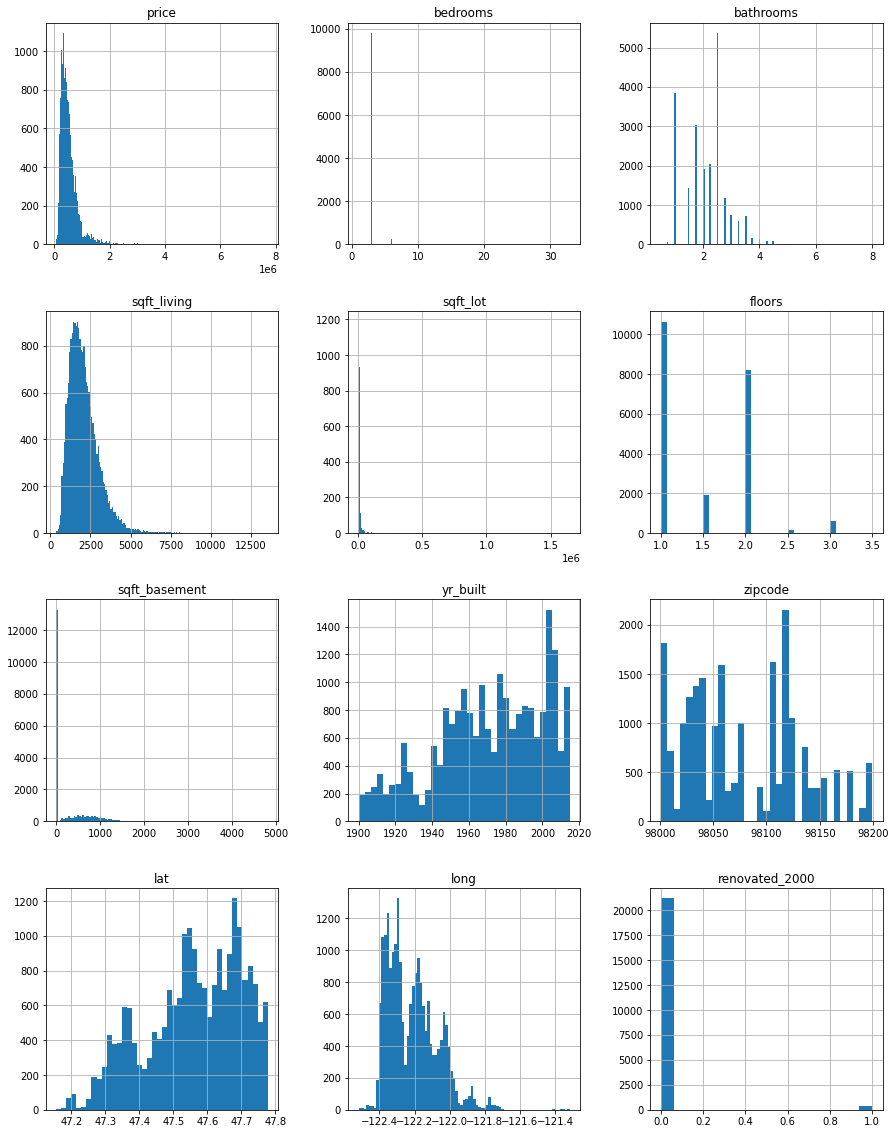

In [39]:
df.hist(figsize=[15,20], bins='auto');

# overall price distribution#######################################3

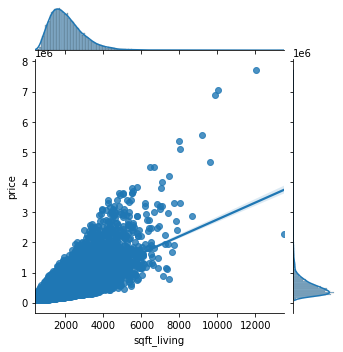

In [40]:
sns.jointplot(x='sqft_living',y='price', data=df, kind='reg', height=5);

In [41]:
#Strong linear connection between sqft_living and price)

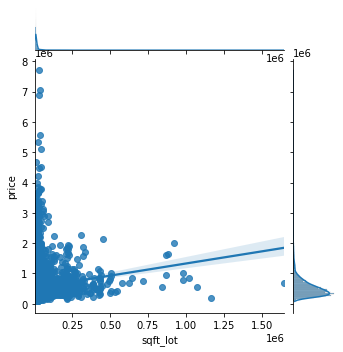

In [42]:
sns.jointplot(x='sqft_lot',y='price', data=df, kind='reg', height=5);

In [43]:
#Much less evidence of linearity here, if any

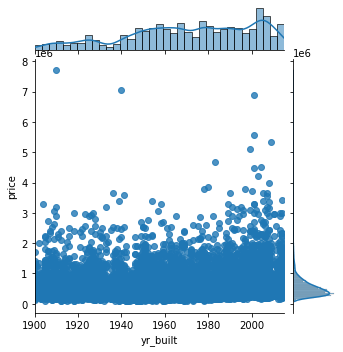

In [44]:
sns.jointplot(x='yr_built',y='price', data=df, kind='reg', height=5);

In [45]:
#No recognizeable linear connection between yr_built and price.

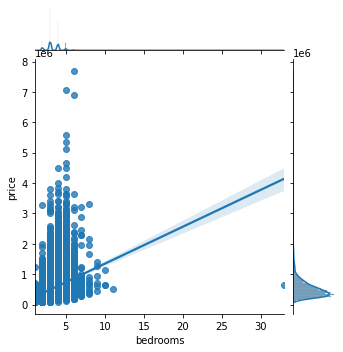

In [46]:
sns.jointplot(x='bedrooms',y='price', data=df, kind='reg', height=5);

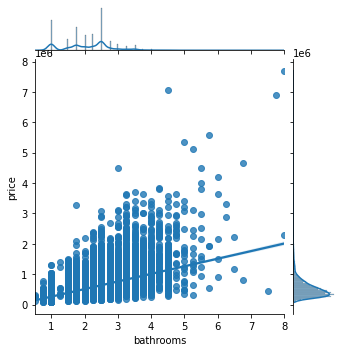

In [47]:
sns.jointplot(x='bathrooms',y='price', data=df, kind='reg', height=5);

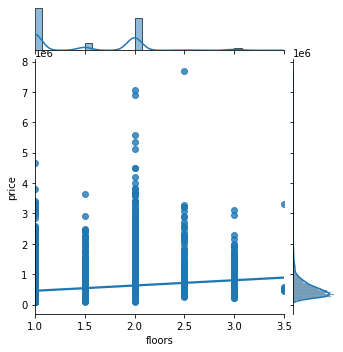

In [48]:
sns.jointplot(x='floors',y='price', data=df, kind='reg', height=5);

Latitude and longitude are best visualized together.

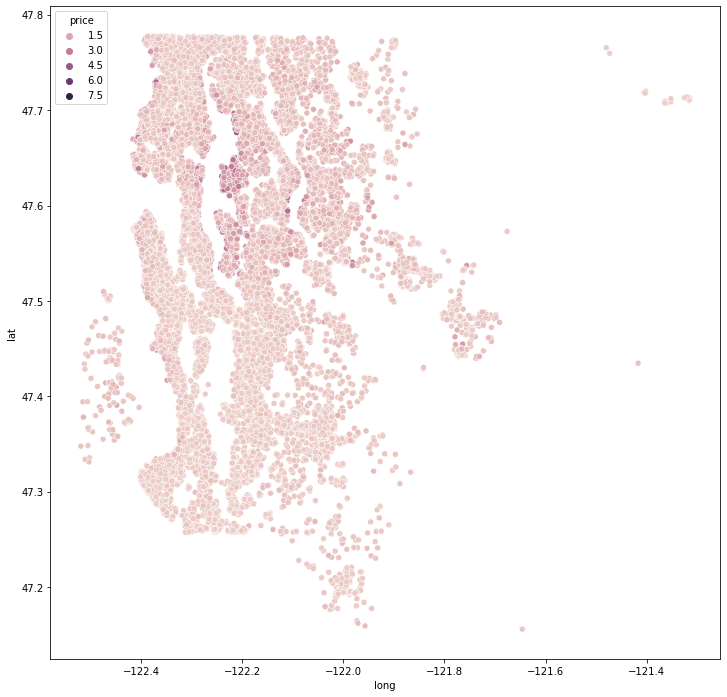

In [59]:
fig = plt.gcf()
fig.set_size_inches(12, 12)
sns.scatterplot(x='long',y='lat',hue='price', data=df);

In [60]:
#notesnotes

In [70]:
# sqft_basement

Next are our non-numerical features.

# MAKE PRETTY! ALL! !############

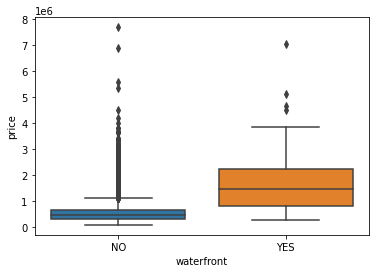

In [54]:
sns.boxplot(x='waterfront',y='price', data=df);

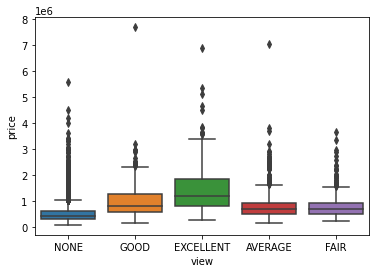

In [55]:
sns.boxplot(x='view',y='price', data=df);

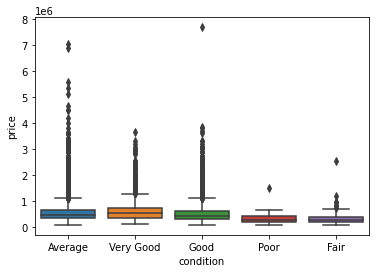

In [56]:
sns.boxplot(x='condition',y='price', data=df);

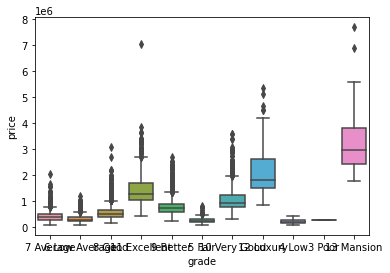

In [22]:
sns.boxplot(x='grade',y='price', data=df);

In [71]:
#has basement

#### One-Hot Encoding Categoricals with Dummy Variables

We need to use one-hot encoding to split these features into data useable by our model. We create dummy variables for each potential variable of the categorical data.

In [62]:
#checking all features for reference
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'has_basement', 'renovated_2000'],
      dtype='object')

In [63]:
categorical_df = df[['renovated_2000', 'grade', 'condition', 'view', 'waterfront', 'has_basement']].astype(str)

In [64]:
dummies_df = pd.get_dummies(categorical_df, drop_first=True)
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   renovated_2000_1     21534 non-null  uint8
 1   grade_11 Excellent   21534 non-null  uint8
 2   grade_12 Luxury      21534 non-null  uint8
 3   grade_13 Mansion     21534 non-null  uint8
 4   grade_3 Poor         21534 non-null  uint8
 5   grade_4 Low          21534 non-null  uint8
 6   grade_5 Fair         21534 non-null  uint8
 7   grade_6 Low Average  21534 non-null  uint8
 8   grade_7 Average      21534 non-null  uint8
 9   grade_8 Good         21534 non-null  uint8
 10  grade_9 Better       21534 non-null  uint8
 11  condition_Fair       21534 non-null  uint8
 12  condition_Good       21534 non-null  uint8
 13  condition_Poor       21534 non-null  uint8
 14  condition_Very Good  21534 non-null  uint8
 15  view_EXCELLENT       21534 non-null  uint8
 16  view_FAIR            2

We can see above that our categorical features has been successfully split into unique dummy variables.

### Continuous Data

The remaining features are continuous numerical data. We will not include the price feature going forward with the transformations, as it is the feature we want to train our model to predict.

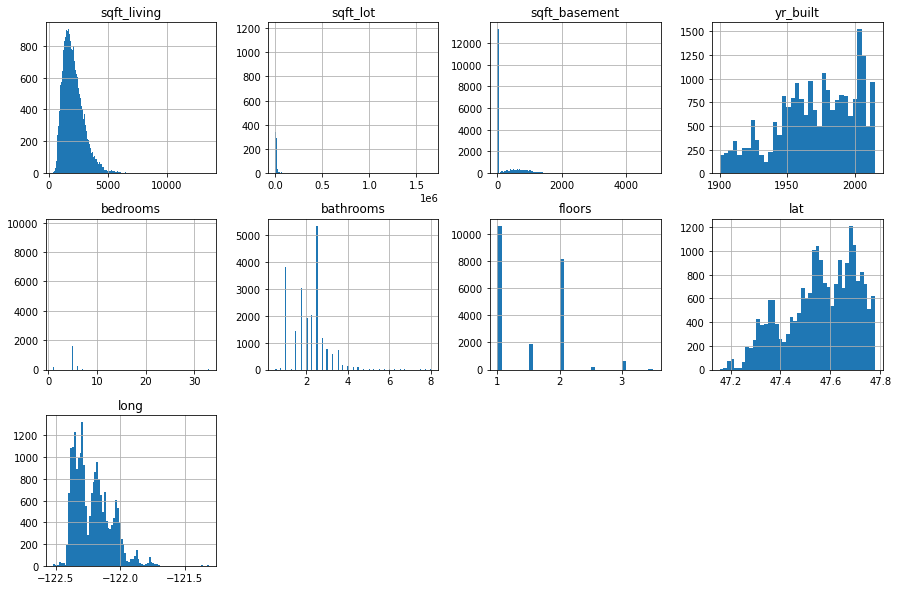

In [68]:
continuous_df = df[['sqft_living','sqft_lot','sqft_basement', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'lat', 'long']]

continuous_df.hist(figsize=[15,10], bins='auto', layout=(3,4));

### Transforming and Standardizing Data

This data is extremely skewed, so we will use the log transform to make the data more normally distributed.

<ipython-input-69-655a2ed7b1f7>:1: RuntimeWarning: divide by zero encountered in log
  continuous_log = np.log(continuous_df)
<ipython-input-69-655a2ed7b1f7>:1: RuntimeWarning: invalid value encountered in log
  continuous_log = np.log(continuous_df)


ValueError: supplied range of [-inf, 8.480529207044645] is not finite

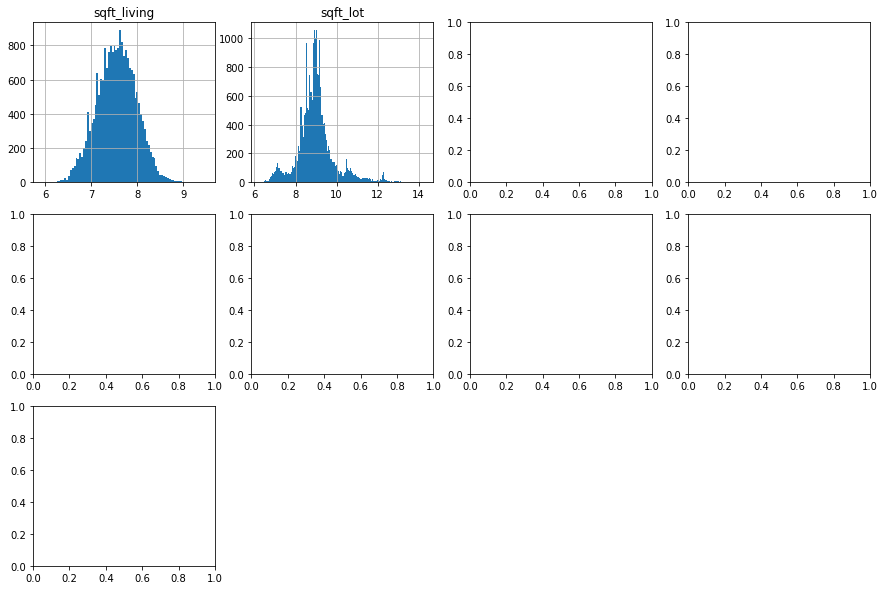

In [69]:
continuous_log = np.log(continuous_df)
continuous_log.hist(figsize=[15,10], bins='auto', layout=(3,4));

Now that the data has been transformed, we standardize it in order to properly scale the continuous features in relation to each other.

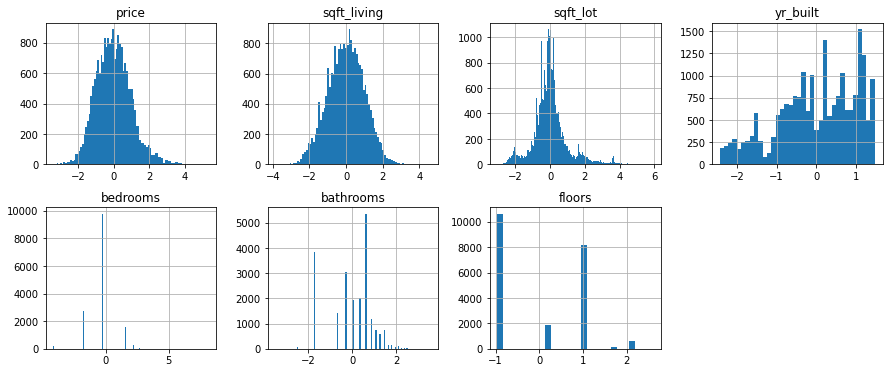

In [9]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
#normalize data

normalized_cont = continuous_log.apply(normalize)
normalized_cont.hist(figsize=[15,6], bins='auto', layout=(2,4));

### Final Preprocessed Dataset

We can tell from the above exploration that there are certainly at least some features with strong linearity compared to the price, as well as some features that show strong multicollinearity, which we will attempt to deal with in the next steps.

Finally, we combine the continuous and categorical features back into a final preprocessed dataset. This will be composed solely of the original preprocessed continuous variables, and the categorical dummies from before.

In [23]:
final_df = pd.concat([normalized_cont, dummies_df], axis=1)

final_df.describe()

,price,sqft_living,sqft_lot,yr_built,bedrooms,bathrooms,floors,renovated_2000_1,grade_11 Excellent,grade_12 Luxury,...,grade_9 Better,condition_Fair,condition_Good,condition_Poor,condition_Very Good,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,waterfront_YES
count,2.153400e+04,2.153400e+04,2.153400e+04,2.153400e+04,2.153400e+04,2.153400e+04,2.153400e+04,21534.000000,21534.000000,21534.000000,...,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000
mean,1.420162e-15,-2.956470e-15,-4.117941e-16,1.875247e-14,-4.619485e-16,-1.267059e-16,1.055882e-16,0.017600,0.018436,0.004087,...,0.120925,0.007894,0.262701,0.001347,0.078806,0.014721,0.015325,0.023591,0.901923,0.006734
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.131496,0.134525,0.063797,...,0.326048,0.088502,0.440111,0.036674,0.269441,0.120436,0.122843,0.151773,0.297426,0.081783
min,-3.388853e+00,-3.859443e+00,-3.032095e+00,-2.445072e+00,-4.158000e+00,-3.492599e+00,-9.607351e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.949050e-01,-6.721235e-01,-5.147356e-01,-6.743950e-01,-2.794053e-01,-3.005899e-01,-9.607351e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-5.897152e-02,1.023752e-02,-5.702629e-02,1.429089e-01,-2.794053e-01,3.397531e-01,1.901427e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,6.250455e-01,6.915643e-01,3.183784e-01,8.834260e-01,7.362416e-01,6.082092e-01,1.006703e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.336605e+00,4.627728e+00,5.904585e+00,1.483261e+00,8.186242e+00,3.571889e+00,2.595125e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\shade\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


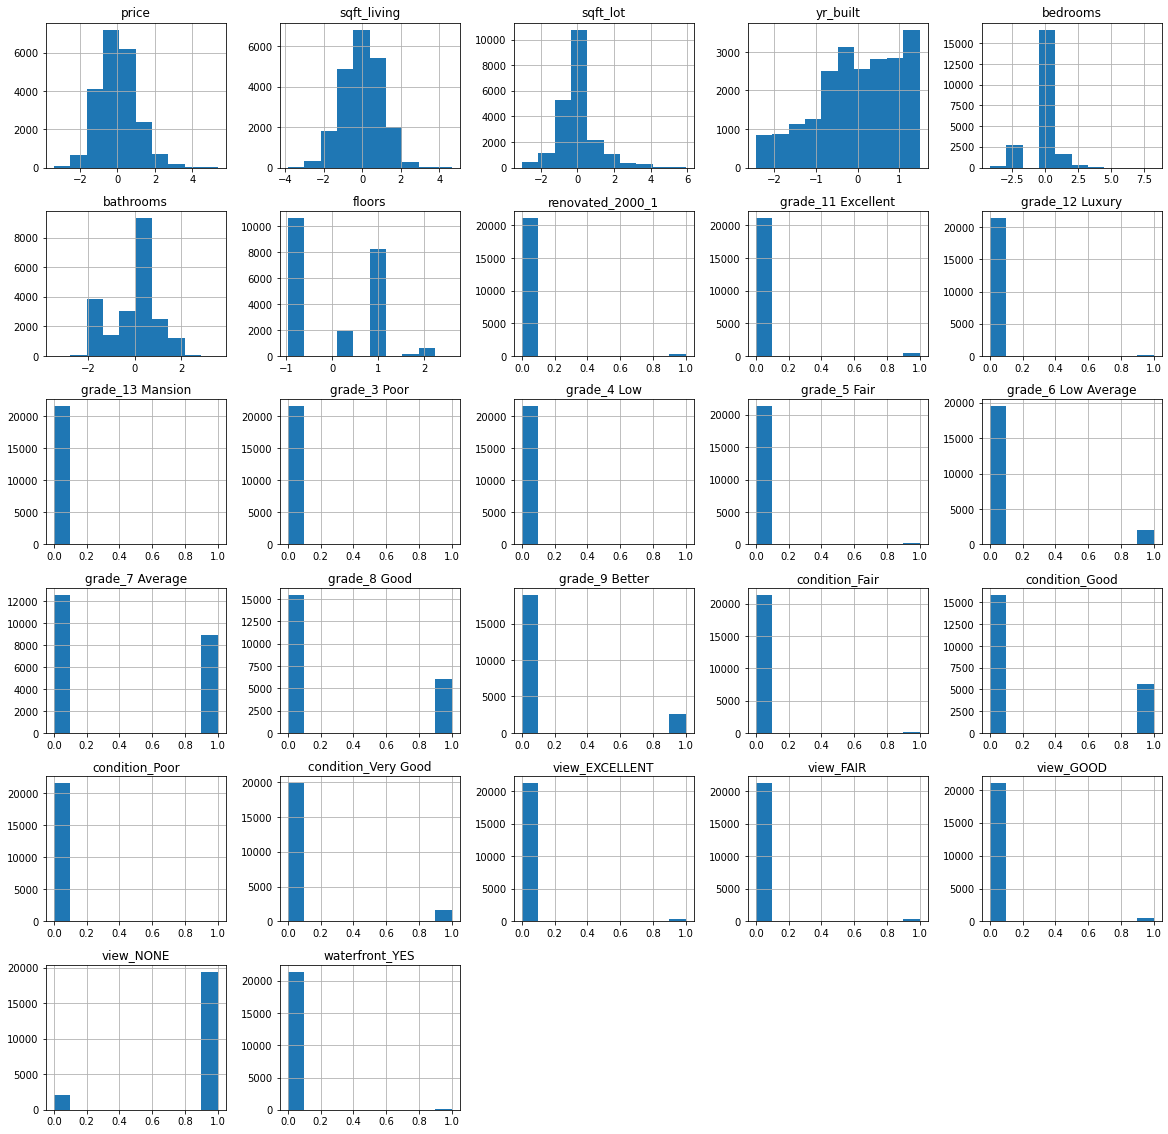

In [24]:
final_df.hist(figsize = (20,20));

In [25]:
final_df.to_csv('./data/preprocessed.csv')

In [26]:
#creating un-standardized un-transformed version for future testing

untransformed_df = pd.concat([continuous_df, dummies_df], axis=1)
untransformed_df.to_csv('./data/untransformed.csv')

## Modeling Data
Now we can preprocess our cleaned data and further explore features in order to prepare for modeling:

[Data Modeling Notebook](./kc_data_modeling.ipynb)